# 1 导入相关库

In [16]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sam2.build_sam import build_sam2_video_predictor

# 张量计算时的精度设置
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True


# 2 加载sam2模型

In [ ]:
checkpoint = "D:\GitHub\Intelligent_Video_Target_Elimination_and_Semantic_Editing_System_for_Mobile_Devices\sam2\sam2.1_hiera_tiny.pt"
model_cfg = "D:\GitHub\Intelligent_Video_Target_Elimination_and_Semantic_Editing_System_for_Mobile_Devices\sam2\sam2.1_hiera_t.yaml"
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

# 3 定义相关显示函数

In [3]:
# 定义相关显示函数
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   


# 4 将视频保存为帧

In [4]:
import subprocess
import os

def extract_frames(input_video, output_folder, quality=2, start_number=0):
    # 确保输出文件夹存在
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # 构建FFmpeg命令
    command = [
        'ffmpeg',
        '-i', input_video,
        '-q:v', str(quality),
        '-start_number', str(start_number),
        os.path.join(output_folder, '%05d.jpg')
    ]
    
    # 运行FFmpeg命令
    try:
        subprocess.run(command, check=True)
        print(f"视频帧已成功提取到 {output_folder}")
    except subprocess.CalledProcessError as e:
        print(f"FFmpeg命令执行失败: {e}")

# 使用示例
input_video = r'd:\test1\video016.mp4'
output_folder = 'output'
extract_frames(input_video, output_folder)


视频帧已成功提取到 output


# 5 读取包含所有视频帧的图片路径

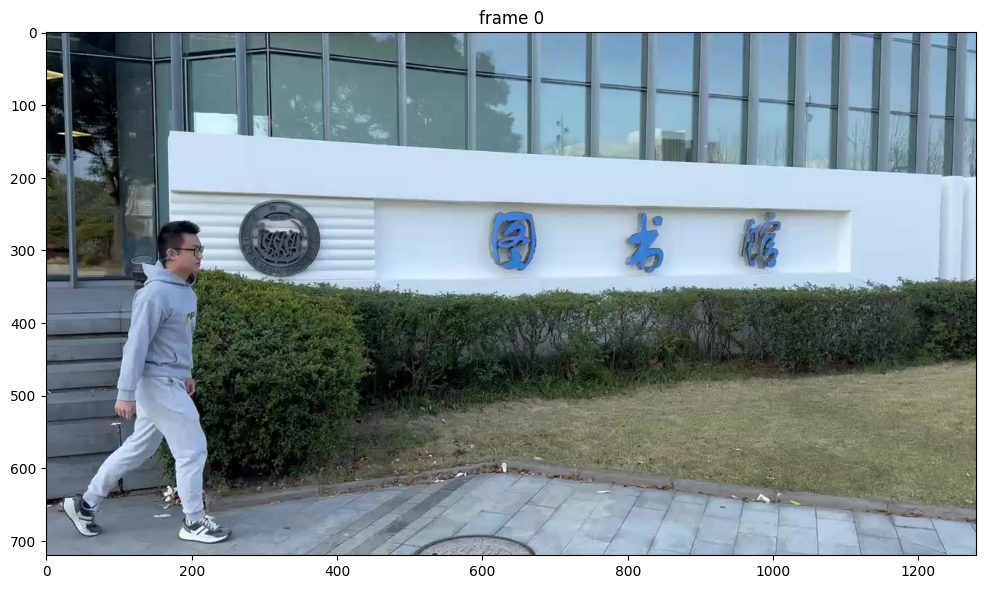

In [5]:
#  读取包含所有视频帧的图片路径
video_dir = "./output"
if not os.path.exists(video_dir):
    os.makedirs(video_dir)

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(12, 8))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))


# 6 初始化推理状态

In [6]:
inference_state = predictor.init_state(video_path=video_dir)


frame loading (JPEG):   0%|          | 0/78 [00:00<?, ?it/s]

frame loading (JPEG): 100%|██████████| 78/78 [00:01<00:00, 40.93it/s]


# eg1：分割追踪单个目标

## step1：在模型中添加分割提示点

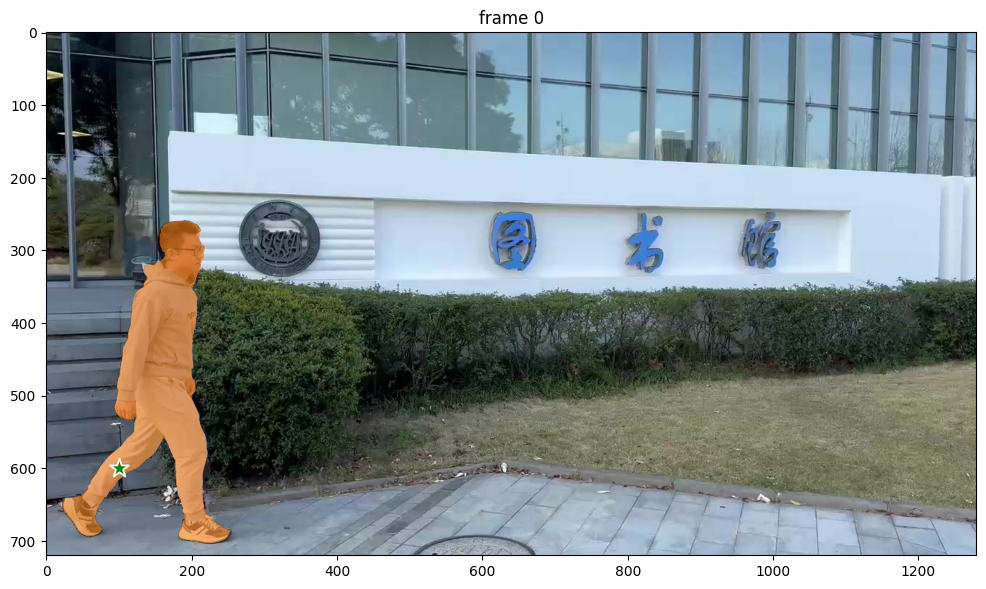

In [13]:
# 视频帧序号
ann_frame_idx = 0  
# 为每一个分割目标建立一个唯一id, 任意整数
ann_obj_id = 1  

# 添加一个前景点
points = np.array([[100, 600]], dtype=np.float32)
# 1表示前景点，0表示背景点
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# 显示分割结果
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])


## step2：在视频中传播获取 masklet(时空掩码) 的提示

propagate in video: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s]


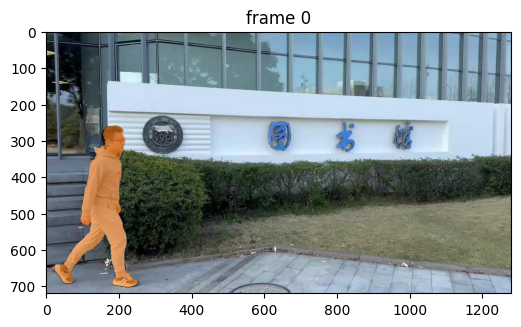

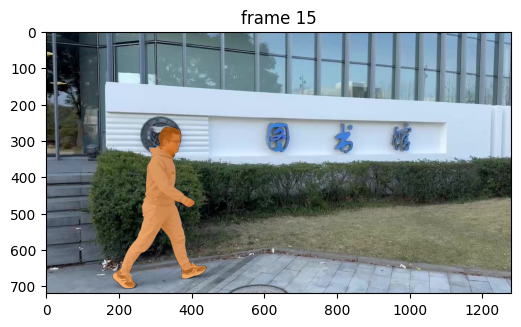

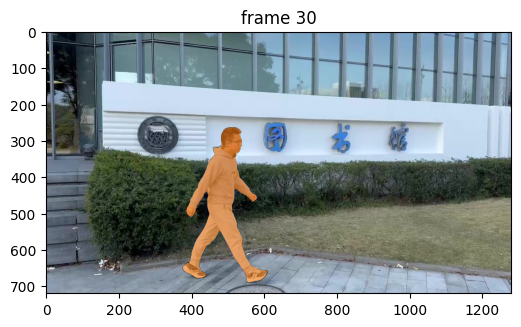

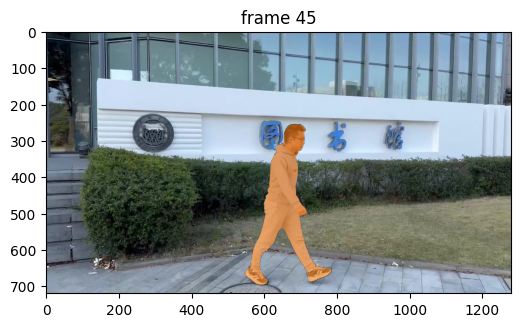

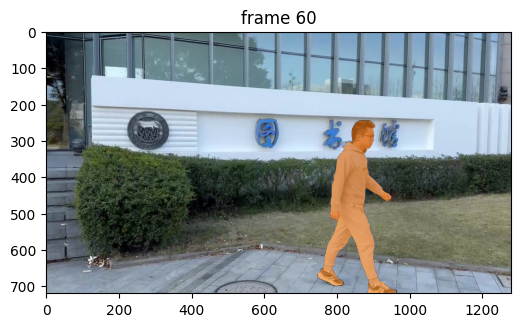

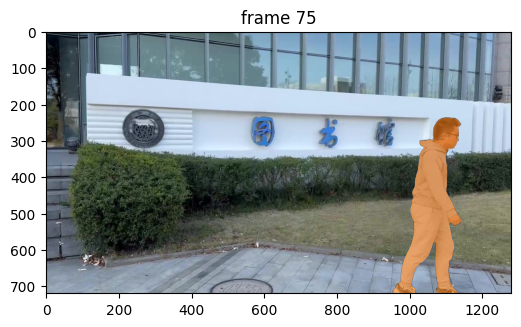

In [8]:
# 在整个视频中运行传播，并在字典中存储结果
video_segments = {}  # Video_segments包含每帧分割结果
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# 每隔几帧显示分割结果
vis_frame_stride = 15
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)


## step3：保存每一帧分割结果

In [ ]:
import cv2

colors = [np.array([0, 128, 255], dtype=np.uint8),
         np.array([255, 128, 0], dtype=np.uint8)]

def add_mask2(image, mask, color_id):
    # 单通道
    int_mask = mask.astype(np.uint8)
    int_mask_3d = np.dstack((int_mask, int_mask, int_mask))
    # 创建橙色掩码图像
    # 橙色 (B, G, R)
    mask_color = colors[color_id]
    mask = np.full_like(image, mask_color)

    # 将掩码应用于橙色掩码图像
    mask[int_mask == 0] = 0

    # 使用 cv2.addWeighted 叠加原始图像和橙色掩码图像
    alpha = 0.6  # 原始图像权重
    beta = 1 - 0.6  # 橙色掩码权重
    gamma = 0  # 偏移量

    # 使用掩码矩阵来控制叠加
    res = cv2.addWeighted(image, alpha, mask, beta, gamma, dtype=cv2.CV_8U)

    # 将mask中为黑色部分保留原图,0的区域为True, 非零区域为False
    # 获取黑色区域
    black_areas = int_mask_3d == 0
    res[black_areas] = image[black_areas]
    return res


for out_frame_idx in range(0, len(frame_names)):
    color_num = 0
    now_img = cv2.imread(os.path.join(video_dir, frame_names[out_frame_idx]))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        now_img = add_mask2(now_img, np.squeeze(out_mask),color_num)
        color_num += 1
    mask_out_name = 'masks2/{}.jpg'.format(str(out_frame_idx).zfill(5))
    cv2.imwrite(mask_out_name, now_img)


## step4：合成视频

In [12]:
import subprocess
import os

def create_video_from_frames(input_folder, output_video, framerate=30, codec='libx264', pix_fmt='yuv420p'):
    # 构建FFmpeg命令
    command = [
        'ffmpeg',
        '-framerate', str(framerate),
        '-i', os.path.join(input_folder, '%05d.jpg'),
        '-c:v', codec,
        '-pix_fmt', pix_fmt,
        output_video
    ]
    
    # 运行FFmpeg命令
    try:
        subprocess.run(command, check=True)
        print(f"视频已成功创建为 {output_video}")
    except subprocess.CalledProcessError as e:
        print(f"FFmpeg命令执行失败: {e}")

# 使用示例
input_folder = 'D:\GitHub\Intelligent_Video_Target_Elimination_and_Semantic_Editing_System_for_Mobile_Devices\sam2\masks2'  # 包含图像文件的文件夹路径
output_video = 'D:\GitHub\Intelligent_Video_Target_Elimination_and_Semantic_Editing_System_for_Mobile_Devices\sam2\output.mp4'  # 输出视频文件的路径
create_video_from_frames(input_folder, output_video)


视频已成功创建为 D:\GitHub\Intelligent_Video_Target_Elimination_and_Semantic_Editing_System_for_Mobile_Devices\sam2\output.mp4


# eg2：分割多个对象